# Notebook to Analyze the Efficacy of Generative Models for Anomaly Detection

In this notebook we will look to use different generative models on graphs to learn distributions over normal graphs and hopefully detect some anomalies. We specifically start our experimentation looking at the GraphRNN framework implemented by the SNAP group

In [3]:
# Fun some setup for the project
# Silence annoying pytorch deprecated warnings
import warnings
warnings.filterwarnings("ignore")

from train import *
%matplotlib inline

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# All necessary arguments are defined in args.py
args = Args()
os.environ['CUDA_VISIBLE_DEVICES'] = str(args.cuda)
print('CUDA', args.cuda)
print ('CUDA Available:', torch.cuda.is_available())
print('File name prefix',args.fname)

CUDA 1
CUDA Available: True
File name prefix GraphRNN_RNN_ladder_small_4_64_


In [4]:
# Set the type of graph that we want to evaluate the log likelihoods of
args.change_dataset("enzymes_small")

In [5]:
# Load the graph data - Consider using presaved datasets! with graph load list
graphs = create_graphs.create(args)

# split datasets
random.seed(123)
shuffle(graphs)
graphs_len = len(graphs)
graphs_test = graphs[int(0.8 * graphs_len):]
graphs_train = graphs[0:int(0.8*graphs_len)]
graphs_validate = graphs[0:int(0.2*graphs_len)]

Loading graph dataset: ENZYMES
Loaded


In [6]:
# Display some graph stats
graph_validate_len = 0
for graph in graphs_validate:
    graph_validate_len += graph.number_of_nodes()
graph_validate_len /= len(graphs_validate)
print('graph_validate_len', graph_validate_len)

graph_test_len = 0
for graph in graphs_test:
    graph_test_len += graph.number_of_nodes()
graph_test_len /= len(graphs_test)
print('graph_test_len', graph_test_len)


args.max_num_node = max([graphs[i].number_of_nodes() for i in range(len(graphs))])
max_num_edge = max([graphs[i].number_of_edges() for i in range(len(graphs))])
min_num_edge = min([graphs[i].number_of_edges() for i in range(len(graphs))])

# show graphs statistics
print('total graph num: {}, training set: {}'.format(len(graphs),len(graphs_train)))
print('max number node: {}'.format(args.max_num_node))
print('max/min number edge: {}; {}'.format(max_num_edge,min_num_edge))
print('max previous node: {}'.format(args.max_prev_node))

graph_validate_len 15.666666666666666
graph_test_len 15.136363636363637
total graph num: 109, training set: 87
max number node: 20
max/min number edge: 49; 17
max previous node: 15


In [7]:
# Initialize the dataset and dataloader for analyzing the nlls. 
# Note that we use batch_size = 1 because we want the nll for each
# data point not an average across a batch.
# We should also consider using Graph_sequence_Sampler_pytorch_nll.
# This sampler expands the size of the dataset by for each graph 
# creating many different bfs permutations. The idea behind this sampler
# is to test the models permutation invariance. 

train_dataset = Graph_sequence_sampler_pytorch(graphs_train,max_prev_node=args.max_prev_node,max_num_node=args.max_num_node)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=args.num_workers)

test_dataset = Graph_sequence_sampler_pytorch(graphs_test, max_prev_node=args.max_prev_node,max_num_node=args.max_num_node)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=args.num_workers)



In [8]:
# Model initialization
# Using GraphRNN

rnn = GRU_plain(input_size=args.max_prev_node, embedding_size=args.embedding_size_rnn,
                        hidden_size=args.hidden_size_rnn, num_layers=args.num_layers, has_input=True,
                        has_output=True, output_size=args.hidden_size_rnn_output).to(device)
output = GRU_plain(input_size=1, embedding_size=args.embedding_size_rnn_output,
                        hidden_size=args.hidden_size_rnn_output, num_layers=args.num_layers, has_input=True,
                        has_output=True, output_size=1).to(device)

In [13]:
# This function encapsulates the process of getting the loglikelihoods
# of the data
def calc_nll(args, data_loader, rnn, output, max_iter=100, load_epoch=3000):
    """
        For now the max_iter is not used. However, the idea in the future
        is to do max_iter loops of calculating the nlls of the data. Since
        the model is permutation dependent, namely we use a random bfs ordering
        for each graph when training/testing, we should do many iterations to
        test the robustness of the model to permutation. This could also be
        addressed using nll data_loader. 
    """
    # Set the epoch we are loading from
    args.load_epoch = load_epoch
    fname = args.model_save_path + args.fname + 'lstm_' + str(args.load_epoch) + '.dat'
    rnn.load_state_dict(torch.load(fname))
    fname = args.model_save_path + args.fname + 'output_' + str(args.load_epoch) + '.dat'
    output.load_state_dict(torch.load(fname))

    epoch = args.load_epoch
    print('model loaded!, epoch: {}'.format(args.load_epoch))

    # Calculate nll over dataset max_iter times,
    # to test robustness to permutations of the bfs
    # ordered adjacency matrix for the same graphs.
    nlls = []
    for i in range(max_iter):
        nll = rnn_data_nll(args, rnn, output, data_loader)
        # Logging info
        # May want to also include std statistics
        if (i + 1) % 10 == 0:
            print ("Iteration:", i + 1)
            print ("Average Nll:", np.mean(nll))
            
        nlls.extend(nll)
        
    return nlls

model loaded!, epoch: 3000
Iteration: 9
Average Nll: 27.181960089453334
Iteration: 19
Average Nll: 27.181960089453334
Iteration: 29
Average Nll: 27.181960089453334
Iteration: 39
Average Nll: 27.181960089453334
Iteration: 49
Average Nll: 27.181960089453334
Iteration: 59
Average Nll: 27.181960089453334
Iteration: 69
Average Nll: 27.181960089453334
Iteration: 79
Average Nll: 27.181960089453334
Iteration: 89
Average Nll: 27.181960089453334
Iteration: 99
Average Nll: 27.181960089453334


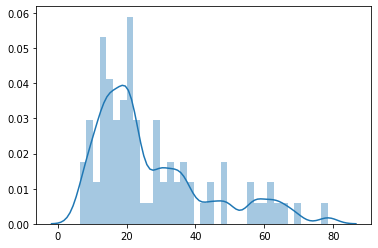

In [14]:
# Let's do some analysis on the training data
nlls = calc_nll(args, train_loader, rnn, output)
plt.figure()
sns.distplot(nlls, kde=True)
#plt.xlim([0, 55])

model loaded!, epoch: 3000


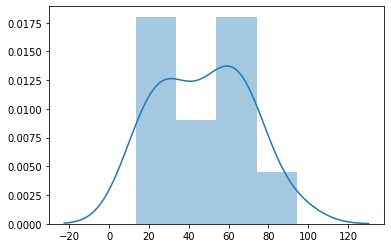

In [18]:
# Analysis of the test data set nlls.
nlls = calc_nll(args, test_loader, rnn, output)
plt.figure()
sns.distplot(nlls, kde=True)